In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np

import random
import h5py
from keras.datasets import cifar10
from keras.models import *
from keras.layers import *
from keras.layers.core import *
from keras.layers.normalization import *
from keras.optimizers import *
from keras.callbacks import *
from keras import backend as K
from keras.regularizers import *
import theano.tensor as T
import theano
from theano.tensor.shared_randomstreams import RandomStreams
from sklearn import metrics
from skimage.measure import compare_ssim
from scipy.misc import toimage
from sklearn.preprocessing import *

import os
import random
import time
from skimage import io, exposure, feature, color, transform
import matplotlib
import matplotlib.pyplot as plt
import glob

import scipy.signal as sig
import operator
import math

# for reproducibility
np.random.seed(1337) 
random.seed(1337)

Using Theano backend.
Using gpu device 1: GeForce GTX 690 (CNMeM is disabled, cuDNN 5105)


In [2]:
# parameters for sliding window, and window function (Hann)
STEP_SIZE = 480
OVERLAP_SIZE = 32
WINDOW_SIZE = STEP_SIZE + OVERLAP_SIZE
OVERLAP_FUNC = sig.hann(OVERLAP_SIZE * 2)

# directory that contains TIMIT files
TIMIT_DIR = "/home/sri/Desktop/timit"

# directory that contains .wav files to process
NUM_EPOCHS = 1
BATCH_SIZE = 64

# randomly shuffle data before partitioning into training/validation?
RANDOM_SHUFFLE = True

# sample rate of input file (used in MFCC calculation)
SAMPLE_RATE = 16000

In [3]:
from load_TIMIT import *
from windowingFunctions import *
from utility import *

In [4]:
# read in 100 WAVs from TIMIT training set
rawWaveforms = load_TIMIT_train(TIMIT_DIR, 1000)

Reading in .wav files...


In [5]:
# waveform preprocessing
def preprocessWaveform(waveform):   
    return waveform, ()
   
def unpreprocessWaveform(waveform, params):
    return waveform



# window preprocessing
def preprocessWindows(windows):
    # scale window between -1 and 1
    processed = np.copy(windows)
   
    mn = np.min(processed, axis = 1)
    mx = np.max(processed, axis = 1)

    maxabs = np.maximum(np.abs(mn), np.abs(mx))

    for i in xrange(0, processed.shape[0]):
        processed[i] /= maxabs[i]
    #processed *= 0.98
   
    #processed = (processed + 1.0) / 2.0
   
    return processed, (maxabs,)

def unpreprocessWindows(windows, params):
    # scale window from [-1, 1] to [-32768, 32768]
    scl = params[0]
   
    unprocessed = np.copy(windows)
    #unprocessed /= 0.98
   
    #nprocessed = (unprocessed * 2.0) - 1.0
   
    for i in xrange(0, unprocessed.shape[0]):
        unprocessed[i] *= scl[i]

    return unprocessed

In [6]:
# waveform preprocessing
processedWaveforms = np.copy(rawWaveforms)

# we maximize the volume of every waveform
for i in xrange(0, len(processedWaveforms)):
    processedWaveforms[i], _ = preprocessWaveform(processedWaveforms[i])

In [7]:
# extract windows
rawWindows = extractWindowsMultiple(processedWaveforms, STEP_SIZE, OVERLAP_SIZE,
                                    collapse = True)

# randomly shuffle data
if (RANDOM_SHUFFLE):
    rawWindows = np.random.permutation(rawWindows)

print "Raw windows shape: ", rawWindows.shape
print "Max: ", np.amax(rawWindows)
print "Min: ", np.amin(rawWindows)

Raw windows shape:  (101135, 512)
Max:  17885.0
Min:  -17139.0


In [8]:
# data augmentation goes here, at some point
augWindows = np.copy(rawWindows)

print "Aug windows shape: ", augWindows.shape

Aug windows shape:  (101135, 512)


In [9]:
processedWindows, pwParams = preprocessWindows(augWindows)

In [10]:
# reshape into vector form
processedWindows = np.reshape(processedWindows, (processedWindows.shape[0], WINDOW_SIZE, 1))

In [11]:
print processedWindows.shape

print np.mean(processedWindows, axis=None)
print np.std(processedWindows, axis=None)
print np.min(processedWindows, axis = None)
print np.max(processedWindows, axis = None)

(101135, 512, 1)
0.0179514
0.286117
-1.0
1.0


In [12]:
class PhaseShift1D(Layer):
    """ PhaseShift1D
    Takes vector of size: B x S x nF
    And returns vector: B x nS x F
    """
    def __init__(self, n, **kwargs):
        super(PhaseShift1D, self).__init__(**kwargs)
        self.n = n
    
    def build(self, input_shape):
        # no trainable parameters
        self.trainable_weights = []
    
    def call(self, x, mask=None):
        r = T.reshape(x, (x.shape[0], x.shape[1], x.shape[2] / self.n, self.n))
        r = T.transpose(r, (0, 1, 3, 2))
        r = T.reshape(r, (x.shape[0], x.shape[1] * self.n, x.shape[2] / self.n))
        return r

    def get_output_shape_for(self, input_shape):
        return (input_shape[0], input_shape[1] * self.n, input_shape[2] / self.n)
    
    def get_config(self):
        config = {'n' : self.n}
        base_config = super(PhaseShift1D, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [13]:
class UniformNoise(Layer):
    def __init__(self, scale, clip = None, **kwargs):
        self.supports_masking = True
        self.scale = scale
        self.clip = clip
        self.uses_learning_phase = True
        super(UniformNoise, self).__init__(**kwargs)

    def call(self, x, mask=None):
        noise_x = x + K.random_uniform(shape = K.shape(x),
                                       low = -self.scale,
                                       high = self.scale)
        if (self.clip is not None):
            noise_x = K.clip(noise_x, -1.0, 1.0)
        return K.in_train_phase(noise_x, x)

    def get_config(self):
        config = {'scale': self.scale}
        base_config = super(UniformNoise, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


In [70]:
class FixedGaussianNoise(Layer):
    def __init__(self, scale, size, clip = None, **kwargs):
        self.supports_masking = True
        self.uses_learning_phase = True
        self.scale = scale
        self.size = size
        self.noise = None
        super(FixedGaussianNoise, self).__init__(**kwargs)

    def call(self, x, mask=None):
        if (self.noise is None):
            self.noise = K.variable(np.random.normal(0.0, self.scale, self.size))
        
        return x + self.noise[:x.shape[0]]
        #return K.in_train_phase(x + self.noise[:x.shape[0]], x)

    def get_config(self):
        config = {'scale': self.scale, 'size': self.size}
        base_config = super(FixedGaussianNoise, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


In [72]:
class FixedUniformNoise(Layer):
    def __init__(self, scale, size, clip = None, **kwargs):
        self.supports_masking = True
        self.uses_learning_phase = True
        self.scale = scale
        self.size = size
        self.noise = None
        super(FixedUniformNoise, self).__init__(**kwargs)

    def call(self, x, mask=None):
        if (self.noise is None):
            self.noise = K.variable(np.random.uniform(-self.scale, self.scale, self.size))
        
        return x + self.noise[:x.shape[0]]
        #return K.in_train_phase(x + self.noise[:x.shape[0]], x)

    def get_config(self):
        config = {'scale': self.scale, 'size': self.size}
        base_config = super(FixedUniformNoise, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


In [92]:
from keras.activations import softmax, sigmoid

# lambda to compute MSE between 2 vectors
def mse_lambda(vects):
    x, y = vects
    return K.mean(K.square(x - y))

# freeze weights for stacked training
def make_trainable(net, val):
    net.trainable = val
    for l in net.layers:
        l.trainable = val

# we generate a new optimizer of the same kind for every model
# we train
def opti():
    return Adam()

input_dim = (WINDOW_SIZE, 1)
input_size = np.prod(input_dim)
bottleneck_size = 256


tau = K.variable(1.0, name = 'temperature')
anneal_rate = 0.02
min_temperature = 0.1

def annealed_tanh(y):
    #noise = K.random_normal(K.shape(y), 0.0, 0.05)
    #return K.tanh((y + noise) / tau)
    return K.tanh(y / tau)




def encoder_residual_block(output_dim = 64, filt_size = 5, subsample = True):
    def f(input):
        stride = 1
        if (subsample):
            stride = 2
        
        conv1 = Convolution1D(output_dim, filt_size, border_mode = 'same',
                          init = 'he_uniform', activation = 'linear',
                          subsample_length = stride, bias = True)(input)
        #if (subsample):
        #    conv1 = MaxPooling1D(2)(conv1)
        #conv1 = SpatialDropout1D(0.1)(conv1)
        act1 = LeakyReLU(0.3)(conv1)
        
        conv2 = Convolution1D(output_dim, filt_size, border_mode = 'same',
                          init = 'he_uniform', activation = 'linear',
                          bias = True)(act1)
        #conv2 = SpatialDropout1D(0.1)(conv2)
        
        residual = conv2
        shortcut = Convolution1D(output_dim, 1, border_mode = 'same',
                                 init = 'he_uniform', activation = 'linear',
                                 subsample_length = stride, bias = True)(input)
        #if (subsample):
        #    shortcut = MaxPooling1D(2)(shortcut)
        
        m = merge([shortcut, residual], mode = 'sum')
        return LeakyReLU(0.3)(m)
    
    return f

def decoder_residual_block(output_dim = 64, filt_size = 5, upsample = True):
    def f(input):
        nfilts = output_dim
        if (upsample):
            nfilts = output_dim * 2

        conv1 = Convolution1D(nfilts, filt_size, border_mode = 'same',
                          init = 'he_uniform', activation = 'linear',
                          bias = True)(input)
        act1 = LeakyReLU(0.3)(conv1)
        
        conv2 = Convolution1D(nfilts, filt_size, border_mode = 'same',
                          init = 'he_uniform', activation = 'linear',
                          bias = True)(act1)
        
        residual = conv2
        shortcut = Convolution1D(nfilts, 1, border_mode = 'same',
                                 init = 'he_uniform', activation = 'linear',
                                 bias = True)(input)
        
        m = merge([shortcut, residual], mode = 'sum')
        r = LeakyReLU(0.3)(m)
        if (upsample):
            return PhaseShift1D(2)(r)
        else:
            return r
    
    return f
#'''

def hard_tanh(x):
    return K.clip(x, -1.0, 1.0)

# ---------------------------------------------------------------------------
# autoencoder: takes an audio window, compresses it, and tries to reconstruct it
# ---------------------------------------------------------------------------
def autoencoder_structure(dim):
    enc_input = Input(shape = dim)
    
    # corrupt input slightly as a form of regularization
    #enc = GaussianDropout(0.05, input_shape = dim)(enc_input)

    # (512x1) => (512x48)
    #enc = encoder_residual_block(48, 9, False)(enc_input)

    # (512x48) => (256x48)
    enc = encoder_residual_block(128, 5, True)(enc_input)
    
    # (256x48) => (256x48)
    enc = encoder_residual_block(128, 5, False)(enc)

    # (256x48) => (128x48)
    enc = encoder_residual_block(128, 5, False)(enc)
    
    # (128x48) => (128x48)
    enc = encoder_residual_block(128, 5, False)(enc)
    
    # (256x48) => (128x48)
    #enc = encoder_residual_block(64, 5, True)(enc)
    
    # (128x48) => (128x48)
    #enc = encoder_residual_block(48, 5, False)(enc)

    # (128x48) => (128)
    enc = Convolution1D(1, 9, border_mode = 'same',
                              init = 'he_uniform', activation = 'linear',
                              bias = True)(enc)
    enc = FixedGaussianNoise(scale = 3.0, size = (128, bottleneck_size, 1))(enc)
    enc = Activation('tanh')(enc)
    #enc = Lambda(annealed_tanh)(enc)

    enc = Reshape((bottleneck_size,))(enc)
    
    enc = Model(input = enc_input, output = enc)
    
    
    
    
    #dec_input = Input(shape = (bottleneck_size, num_cats))
    dec_input = Input(shape = (bottleneck_size,))
    dec = Reshape((256, 1,))(dec_input)
    
    # (64x1) => (64x48)
    #dec = decoder_residual_block(64, 5, False)(dec)
    
    # (64x48) => (128x48)
    #dec = decoder_residual_block(48, 5, True)(dec)
    
    # (64x1) => (64x48)
    dec = decoder_residual_block(128, 5, False)(dec)
    
    # (64x48) => (128x48)
    dec = decoder_residual_block(128, 5, False)(dec)
    
    # (128x48) => (128x48)
    dec = decoder_residual_block(128, 5, False)(dec)
    
    # (128x48) => (256x48)
    dec = decoder_residual_block(96, 5, True)(dec)
    
    # (256x48) => (256x48)
    #dec = decoder_residual_block(48, 9, False)(dec)

    # (512x48) => (512x1)
    dec = Convolution1D(1, 9, border_mode = 'same',
                              init = 'he_uniform', activation = 'tanh',
                              bias = True)(dec)
    #dec = LeakyReLU(0.3)(dec)
    
    #dec = Reshape((WINDOW_SIZE,))(dec)
    #dec = Dense(WINDOW_SIZE, activation = 'tanh', init = 'identity')(dec)
    #dec = Reshape((WINDOW_SIZE, 1,))(dec)
    
    dec = Model(input = dec_input, output = dec)
    
    return enc, dec

# ---------------------------------------------------------------------------
# discriminator: tries to differentiate between original and reconstructed samples
# ---------------------------------------------------------------------------
def discriminator_structure(dim):
    dsc = Sequential()
    
    dsc.add(Convolution1D(48, 5, border_mode='same', input_shape = dim,
                                    init = 'uniform',
                                    subsample_length = 2, activation = 'linear'))
    dsc.add(LeakyReLU(0.3))
    
    dsc.add(Convolution1D(48, 5, border_mode='same', input_shape = dim,
                                    init = 'uniform',
                                    activation = 'linear'))
    dsc.add(LeakyReLU(0.3))

    dsc.add(Convolution1D(48, 5, border_mode='valid', input_shape = dim,
                                    init = 'uniform',
                                    subsample_length = 2, activation = 'linear'))
    dsc.add(LeakyReLU(0.3))
    
    dsc.add(Convolution1D(48, 5, border_mode='same', input_shape = dim,
                                    init = 'uniform',
                                    activation = 'linear'))
    dsc.add(LeakyReLU(0.3))
    
    dsc.add(Convolution1D(48, 5, border_mode='valid', input_shape = dim,
                                    init = 'uniform',
                                    subsample_length = 2, activation = 'linear'))
    dsc.add(LeakyReLU(0.3))
    
    dsc.add(Flatten())
    
    dsc.add(Dense(64, activation = 'linear'))
    dsc.add(LeakyReLU(0.3))
    dsc.add(Dense(1, activation = 'sigmoid'))
    
    return dsc


# construct autoencoder to be used in adversarial training (AAC - Adversarial AutoenCoder)
# uhhhh... whoops i screwed up the acronym
aac_input = Input(shape = input_dim)
aac_enc, aac_dec = autoencoder_structure(input_dim)
aac_embedding = aac_enc(aac_input)
aac_reconstructed = aac_dec(aac_embedding)

aac_autoencoder = Model(input = [aac_input], output = [aac_reconstructed])
aac_autoencoder.compile(loss = 'mean_squared_error', optimizer = opti())



# construct discriminator: regular
regdsc_input_dim = (WINDOW_SIZE, 1)
regdsc_input = Input(shape = input_dim)
regdsc_struct = discriminator_structure(regdsc_input_dim)

regdsc_label = regdsc_struct(regdsc_input)
aac_reg_label = regdsc_struct(aac_reconstructed)

def code_sparsity_constraint(placeholder, code):
    scaled = (code + 1.0) / 2.0
    return K.mean(scaled, axis = -1)




def code_binary_constraint(placeholder, code):
    return K.mean(K.abs(1.0 - K.abs(code)), axis = -1)

def code_balance_constraint(placeholder, code):
    var = K.var(code, axis = -1) + 0.001
    return 1.0 / var
    #return K.abs(K.sum(code, axis = -1)) / float(bottleneck_size)


def code_laplacian_constraint(placeholder, code):
    return K.mean(K.abs(code), axis = -1)


# compile model
loss_weights = [350.0, 1.0, 0.5]#, 0.5]
n_discrim = 1
n_code = 1
lmult = len(loss_weights) - n_discrim - n_code


make_trainable(aac_autoencoder, False)

aac_discrim_reg = Model(input = [regdsc_input], output = [regdsc_label])
aac_discrim_reg.compile(loss = ['binary_crossentropy'], optimizer = opti())
aac_discrim_reg.summary()

aac_autoencoder.summary()

make_trainable(aac_discrim_reg, False)
make_trainable(aac_autoencoder, True)
model = Model(input = [aac_input], output = [aac_reconstructed] * lmult + \
                                            [aac_reg_label] + \
                                            [aac_embedding] * n_code)
model.compile(loss = ['mean_squared_error', \
                      'binary_crossentropy', \
                      code_sparsity_constraint],#  code_variance],
              loss_weights = loss_weights,
              optimizer = opti())
model.summary()

X_train = np.copy(processedWindows)
ntrain = X_train.shape[0]



____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_16 (InputLayer)            (None, 512, 1)        0                                            
____________________________________________________________________________________________________
sequential_4 (Sequential)        (None, 1)             234081      input_16[0][0]                   
Total params: 234081
____________________________________________________________________________________________________
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_13 (InputLayer)            (None, 512, 1)        0                                            
______________________________________________________________________

In [93]:
def test_discriminator(discriminator, autoencoder, X, y, verbose = True):
    # verify discriminator was trained properly
    y_hat = discriminator.predict(X)
    y_hat[y_hat >= 0.5] = 1
    y_hat[y_hat < 0.5] = 0

    n_total = y.shape[0]
    n_correct = np.sum(np.ravel(y_hat) == y)

    acc = n_correct * 100.0 / n_total
    if (verbose):
        print "Discriminator accuracy: %0.02f pct (%d of %d) right"%(acc, n_correct, n_total)
    return acc

In [94]:
def autoencoderTest(waveFilename, prefix, autoencoder, verbose = True):
    [rate, data] = sciwav.read(waveFilename)
    processedWave, wparams = preprocessWaveform(data)
    windows = extractWindows(processedWave, STEP_SIZE, OVERLAP_SIZE)
    

    # first, write desired reconstruction
    transformed, tparams = preprocessWindows(windows)
    if (verbose):
        print transformed.shape
    
    desired = unpreprocessWindows(transformed, tparams)
    desired = reconstructFromWindows(desired, OVERLAP_SIZE, OVERLAP_FUNC)
    desired = unpreprocessWaveform(desired, wparams)
    #sciwav.write(prefix + "_res_desired.wav", rate, desired.astype(np.int16))
    
    # then, run NN on transformed windows
    transformed, tparams = preprocessWindows(windows)
    
    transformed = np.reshape(transformed, (transformed.shape[0], WINDOW_SIZE, 1))
    autoencOutput = autoencoder.predict(transformed, batch_size = BATCH_SIZE, verbose = (1 if verbose else 0))
    if (verbose):
        print autoencOutput.shape
    autoencOutput = np.reshape(autoencOutput, (autoencOutput.shape[0], WINDOW_SIZE))
    
    if (verbose):
        print autoencOutput.shape
    recons = unpreprocessWindows(autoencOutput, tparams)
    recons = reconstructFromWindows(recons, OVERLAP_SIZE, OVERLAP_FUNC)
    recons = unpreprocessWaveform(recons, wparams)
    
    sciwav.write(prefix + "_output.wav", rate, recons.astype(np.int16))
    
    metrics = [
        np.max(desired),
        np.min(desired),
        np.max(recons),
        np.min(recons),
        mse(recons, desired),
        avgErr(recons, desired)
    ]
    
    if (verbose):
        print "Max/min desired:", metrics[0], metrics[1]
        print "Max/min recons: ", metrics[2], metrics[3]
        print waveFilename, " mse: ", metrics[4]
        print waveFilename, " avg err: ", metrics[5]
        
    return metrics

In [95]:
# interleave two numpy arrays of the same size along the first axis
def interleave(a, b):    
    r = np.empty(a.shape)
    r = np.repeat(r, 2, axis = 0)
    
    r[::2] = a
    r[1::2] = b
    return r

In [96]:
np.set_printoptions(formatter={'float_kind':'{:4f}'.format})

BATCH_SIZE = 128
NUM_BATCHES = ntrain / BATCH_SIZE
NUM_EPOCHS = 25

lead = "    "
d_loss = 0.0
a_losses = []
d_acc = 0.0
discrim_train_y = np.concatenate((np.ones(ntrain), np.zeros(ntrain)))


for epoch in range(NUM_EPOCHS):
    print "Epoch " + str(epoch + 1) + ":"

    # present batches randomly each epoch
    lis = range(0, ntrain, BATCH_SIZE)
    random.shuffle(lis)
    
    # keep track of start time and current batch #
    i = 0
    startTime = time.time()
    for idx in lis:
        batch = X_train[idx:idx+BATCH_SIZE, :,  :]
        nbatch = batch.shape[0]
        
        a_losses = ["autoencoder not training"]
        d_loss = "discriminator not training"
        
        # train autoencoder, if discriminator accuracy is greater than 70%
        if (epoch > 0):
            make_trainable(aac_autoencoder, True)
            make_trainable(aac_discrim_reg, False)
            
            a_y = [batch] * lmult + \
                  [np.ones(nbatch)] * n_discrim + \
                  [np.zeros((nbatch, bottleneck_size))] * n_code
            a_losses = model.train_on_batch(batch, a_y)
        
        # train discriminator(s) on what the autoencoder now generates
        generated = aac_autoencoder.predict(batch)
        discrim_batch_X = interleave(batch, generated)
        discrim_batch_y = interleave(np.ones(nbatch), np.zeros(nbatch))
        
        make_trainable(aac_autoencoder, False)
        make_trainable(aac_discrim_reg, True)
        d_loss = aac_discrim_reg.train_on_batch(discrim_batch_X, discrim_batch_y)
        
        if (epoch == 0 and d_loss < 0.2):
            print ""
            print lead + "Terminating epoch early (don't wanna overfit!)"
            break
        
        # print statistics every 10 batches so we know stuff is still going down
        if (i % 10 == 0):
            printStr = "        \r" + lead + str(i * BATCH_SIZE) + ": " + str(d_loss) + " "
            print printStr,
            
            loss_arr = np.asarray(a_losses)
            print loss_arr,
            
            if (len(loss_arr) > 1):
                for i in xrange(0, len(loss_weights)):
                    loss_arr[i + 1] *= loss_weights[i]
                print loss_arr,
            
            print K.get_value(tau),
            #K.set_value(tau, np.max([K.get_value(tau) * np.exp(-anneal_rate * (epoch + 1)), min_temperature]))
            K.set_value(tau, np.max([K.get_value(tau) * (1 - anneal_rate), min_temperature]))
            
        i += 1
    print ""
    
    # print elapsed time for epoch
    elapsed = time.time() - startTime
    print lead + "Total time for epoch: " + str(elapsed) + "s"
    
    
    # ---------------------------------------------------------
    # evaluate discriminator on random samples every epoch
    # ---------------------------------------------------------
    startTime = time.time()
    print lead + "----------------"

    NUM = 200
    rows = np.random.randint(X_train.shape[0], size = NUM)
    generated = aac_autoencoder.predict(X_train[rows, :], verbose = 0)
    d_X = np.concatenate((X_train[rows, :], generated))
    d_y = np.concatenate((np.ones(NUM), np.zeros(NUM)))
    d_acc = test_discriminator(aac_discrim_reg, aac_autoencoder,
                               d_X, d_y, verbose = False)

    print lead + "Evaluated the discriminator: " + str(d_acc) + "% d_acc"
    elapsed = time.time() - startTime
    print lead + "Total time for evaluation: " + str(elapsed) + "s"
    
    
    # ---------------------------------------------------------
    # evaluate autoencoder on real data every epoch
    # ---------------------------------------------------------
    startTime = time.time()
    print lead + "----------------"
    
    print lead + "Evaluating autoencoder..."
    metrics = autoencoderTest("./SA1.WAV", "SA1_res_reg_train_epoch" + str(epoch+1), aac_autoencoder, verbose = False)
    
    print lead + "Max/min desired:", metrics[0], metrics[1]
    print lead + "Max/min recons: ", metrics[2], metrics[3]
    print lead + "MSE:     ", metrics[4]
    print lead + "Avg err: ", metrics[5]
    elapsed = time.time() - startTime
    print lead + "Total time for evaluation: " + str(elapsed) + "s"
    
    print ""

Epoch 1:
    1280: 0.323277175426  ['autoencoder not training'] 0.980000019073 
    Terminating epoch early (don't wanna overfit!)

    Total time for epoch: 14.0098059177s
    ----------------
    Evaluated the discriminator: 99.25% d_acc
    Total time for evaluation: 1.35137414932s
    ----------------
    Evaluating autoencoder...
    Max/min desired: 4899.0 -4013.0
    Max/min recons:  4.0254 -2.09324
    MSE:      154617.0
    Avg err:  210.228
    Total time for evaluation: 0.304653167725s

Epoch 2:
    1280: 0.523180782795  [10.124340 0.025354 1.250535] [10.124340 8.873805 1.250535] 0.248084321618

KeyboardInterrupt: 

In [97]:
model.save('model_reg_adversary.h5')
aac_autoencoder.save('auto_reg_adversary.h5')
aac_discrim_reg.save('discrim_reg_adversary.h5')

import h5py
f = h5py.File('model_reg_adversary.h5', 'r+')
del f['optimizer_weights']
f.close()

In [98]:
'''from keras.models import load_model

objs = {'PhaseShift1D' : PhaseShift1D}

model = load_model('model_reg_adversary.h5', objs)
aac_autoencoder = load_model('auto_reg_adversary.h5', objs)
aac_discrim_reg = load_model('discrim_reg_adversary.h5', objs)
'''

"from keras.models import load_model\n\nobjs = {'PhaseShift1D' : PhaseShift1D}\n\nmodel = load_model('model_reg_adversary.h5', objs)\naac_autoencoder = load_model('auto_reg_adversary.h5', objs)\naac_discrim_reg = load_model('discrim_reg_adversary.h5', objs)\n"

In [99]:
enc = model.layers[1].layers
dec = model.layers[2].layers


In [100]:
NUM = 400
rows = np.random.randint(X_train.shape[0], size = NUM)
generated = aac_autoencoder.predict(X_train[rows, :], verbose = 0)
d_X = np.concatenate((X_train[rows, :], generated))
d_y = np.concatenate((np.ones(NUM), np.zeros(NUM)))
d_acc = test_discriminator(aac_discrim_reg, aac_autoencoder,
                           d_X, d_y, verbose = False)

print lead + "Evaluated the discriminator: " + str(d_acc) + "% d_acc"

    Evaluated the discriminator: 65.5% d_acc


In [101]:
autoencoderTest("./SA1.WAV", "SA1_aac_reg_", aac_autoencoder)
autoencoderTest("./SX383.WAV", "SX383_aac_reg_", aac_autoencoder)
autoencoderTest("./fiveYears.wav", "fy_aac_reg_", aac_autoencoder)

(112, 512)
112/112 [==============================] - 0s
(112, 512, 1)
(112, 512)
Max/min desired: 4899.0 -4013.0
Max/min recons:  4707.68 -2827.53
./SA1.WAV  mse:  21083.6
./SA1.WAV  avg err:  77.635
(93, 512)
93/93 [==============================] - 0s
(93, 512, 1)
(93, 512)
Max/min desired: 2961.0 -3057.0
Max/min recons:  3006.17 -2368.73
./SX383.WAV  mse:  14399.1
./SX383.WAV  avg err:  65.9646
(181, 512)
181/181 [==============================] - 0s     
(181, 512, 1)
(181, 512)
Max/min desired: 24636.0 -20122.0
Max/min recons:  20127.0 -14468.8
./fiveYears.wav  mse:  5.30841e+06
./fiveYears.wav  avg err:  1695.69


[24636.0, -20122.0, 20126.951, -14468.784, 5308414.0, 1695.6877]

In [102]:
all_embed = aac_enc.predict(X_train[:10000], batch_size = BATCH_SIZE, verbose = 1)

10000/10000 [==============================] - 12s    


In [103]:
scalars = all_embed.flatten()
log_scalars = np.log((scalars + 1.0) / 2.0)

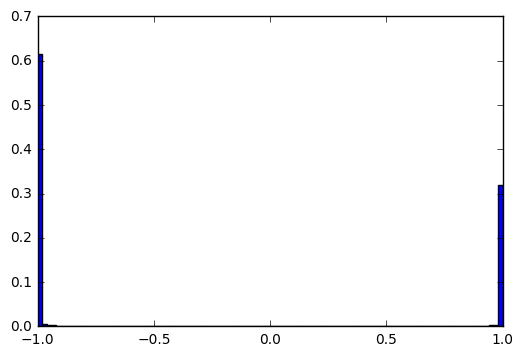

In [104]:
hist = np.histogram(scalars, bins = 101)
sample_hist_probs = hist[0].astype('float32')
sample_hist_bins = hist[1].astype('float32')
sample_hist_probs /= np.sum(sample_hist_probs)

sample_hist_width = 1 * (sample_hist_bins[1] - sample_hist_bins[0])
sample_hist_centers = (sample_hist_bins[:-1] + sample_hist_bins[1:]) / 2
plt.bar(sample_hist_centers, sample_hist_probs, align='center', width=sample_hist_width)

plt.show()

In [105]:
#plt.hist(log_scalars, bins=100)
#plt.show()

In [106]:
# we model the code as a zero-centered Laplacian distribution
#beta = np.mean(np.abs(scalars))
#print beta

# we want to "cut off" at a certain probability
#cutoff_p = 0.01
#clipval = beta * math.log(1.0 / (2.0 * beta * cutoff_p))
#if (clipval > 1.0): clipval = 1.0
#print clipval

0.980528
1.0


In [107]:
#bins = np.linspace(0.0, 1.0, 200)

#bins = np.round(bins * 32.0).astype('int')
#s = set(bins)
#bins = np.array(sorted(list(s))) / 32.0
#bins = (bins * 2.0 - 1.0) * clipval
#print bins

#print len(s)

[-1.000000 -0.937500 -0.875000 -0.812500 -0.750000 -0.687500 -0.625000
 -0.562500 -0.500000 -0.437500 -0.375000 -0.312500 -0.250000 -0.187500
 -0.125000 -0.062500 0.000000 0.062500 0.125000 0.187500 0.250000 0.312500
 0.375000 0.437500 0.500000 0.562500 0.625000 0.687500 0.750000 0.812500
 0.875000 0.937500 1.000000]
33


In [108]:
[rate, data] = sciwav.read("./SA1.WAV")
processedWave, wparams = preprocessWaveform(data)
windows = extractWindows(processedWave, STEP_SIZE, OVERLAP_SIZE)

transformed, tparams = preprocessWindows(windows)

transformed = np.reshape(transformed, (transformed.shape[0], WINDOW_SIZE, 1))
embed = aac_enc.predict(transformed, batch_size = BATCH_SIZE, verbose = 1)

112/112 [==============================] - 0s


In [109]:
print embed[0]

r = np.round(r)

qnt = r[0].astype('int')
print qnt

ent = 1
nbits = ent
for i in xrange(1, len(qnt)):
    if (qnt[i] == qnt[i - 1]):
        nbits += 1
    else:
        nbits += (ent + 1)
print nbits
    
r = r * clipval


print r[0]

autoencOutput = aac_dec.predict(r, batch_size = BATCH_SIZE, verbose = 1)
print autoencOutput.shape
autoencOutput = np.reshape(autoencOutput, (autoencOutput.shape[0], WINDOW_SIZE))

print autoencOutput.shape
recons = unpreprocessWindows(autoencOutput, tparams)

wav = reconstructFromWindows(recons, OVERLAP_SIZE, OVERLAP_FUNC)
wav = unpreprocessWaveform(wav, wparams)

sciwav.write("tst_output_reg.wav", rate, wav.astype(np.int16))

idx = 45

[0.972101 1.000000 0.999715 -1.000000 0.960690 -1.000000 -1.000000
 -0.999999 -0.955066 1.000000 -1.000000 1.000000 1.000000 1.000000 1.000000
 1.000000 -1.000000 0.999403 1.000000 -1.000000 -1.000000 -1.000000
 1.000000 -1.000000 1.000000 1.000000 -1.000000 1.000000 -1.000000 1.000000
 1.000000 -1.000000 1.000000 -1.000000 -1.000000 -1.000000 -1.000000
 1.000000 1.000000 1.000000 -1.000000 -1.000000 -1.000000 1.000000 1.000000
 0.993895 -0.999926 0.999995 1.000000 1.000000 -1.000000 -1.000000 0.978342
 1.000000 1.000000 0.999995 -1.000000 -0.011042 1.000000 1.000000 -1.000000
 -1.000000 -1.000000 -1.000000 1.000000 1.000000 -1.000000 -1.000000
 -1.000000 1.000000 1.000000 -1.000000 0.999998 1.000000 1.000000 0.998448
 -0.951313 1.000000 1.000000 -1.000000 -1.000000 -0.999891 -1.000000
 1.000000 1.000000 -1.000000 1.000000 -1.000000 1.000000 -0.999967 0.995854
 1.000000 0.999982 -1.000000 1.000000 1.000000 -1.000000 -0.967195
 -1.000000 1.000000 1.000000 1.000000 -1.000000 -0.727779 0.

In [113]:
b = np.linspace(-1.0, 1.0, 3)
print b

h = np.histogram(scalars, bins = b)
print h[0]
print h[1]
h = h[0].astype('float32')
h = h / h.sum()
print h

entropy = 0
for i in h:
    if (i < 1e-4): continue
    entropy += i * math.log(i, 2)
entropy = -entropy
print entropy

[-1.000000 0.000000 1.000000]
[1667982  892018]
[-1.000000 0.000000 1.000000]
[0.651555 0.348445]
0.932671204154
